# Pet Classifier

## References
The work in this notebook is inspired from https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

## Introduction

In this assignment, we will explore the use of computer vision techniques to detect the presence of a specific pet in a given image.

The goal of this project is to build a model that can accurately identify whether a given picture contains the user's favorite pet or not. This task is particularly challenging due to the wide variety of possible appearances that a pet can have, as well as the potential presence of other objects in the picture that could confuse the model.

The project will be split into the following steps:
* Dataset loading
* Data exploration
* Preprocessing
* Modelization
* Performances evaluation
* Conclusion

By the end of this assignment, we will have a model that can accurately identify the presence of the user's favorite pet in a given image.

## Dataset Loading

The dataset we will be using is collected images of animals from the internet. The process of collecting the images and building the dataset is defined in [this notebook](Build_Dataset.ipynb).

Any dataset of images can be used, as long as it is of the following format:
```
📂dataset_folder
└───📂favorite_pet
    │   📜favorite_pet_00.jpg
    │   📜favorite_pet_01.jpg
    │   📜....
    📂others
    │   📜others_00.jpg
    │   📜others_01.jpg
    │   📜....
```

Supported image extensions are:
* jpg
* png

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import joblib
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize, rescale
from skimage.color import rgb2gray
import copy
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
def load_dataset(src):
    """
    load images from path and write them as arrays to a dictionary, 
    together with labels and metadata.
     
    Parameter
    ---------
    src: str
        path to data
        
    Return
    ------
    dict
        Dictionary with labels, metadata and image data
    """
    
    data = dict()
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    for subdir in os.listdir(src):
        current_path = os.path.join(src, subdir)

        print(f'Reading files from {subdir}')
        for file in tqdm(os.listdir(current_path)):
            if file[-3:] in {'jpg', 'png'}:
                try:
                    im = imread(os.path.join(current_path, file))
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
                except:
                    print(f'Skipping {os.path.join(current_path, file)}')
    
    return data

In [3]:
data_path = "../datasets/dataset_cat"
dataset = load_dataset(data_path)

Reading files from cat


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.14it/s]


Reading files from others


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.58it/s]


## Data Exploration

Let's take a look at the loaded dataset

In [4]:
print('Number of samples: ', len(dataset['data']))
print('Classes: ', np.unique(dataset['label']))

Number of samples:  200
Classes:  ['cat' 'others']


Let's see the distribution of the images between classes

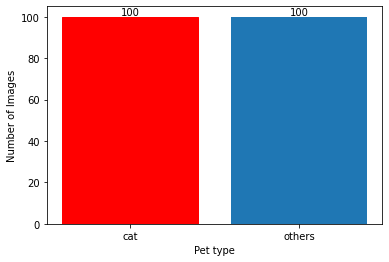

In [5]:
fig, ax = plt.subplots()
unique, counts = np.unique(dataset['label'], return_counts=True)
bars = plt.bar(unique, counts)
bars[0].set_color('r')
ax.bar_label(bars)
plt.xlabel('Pet type')
plt.ylabel('Number of Images')
plt.show()

And finally, let's take a look at the some of the loaded pictures

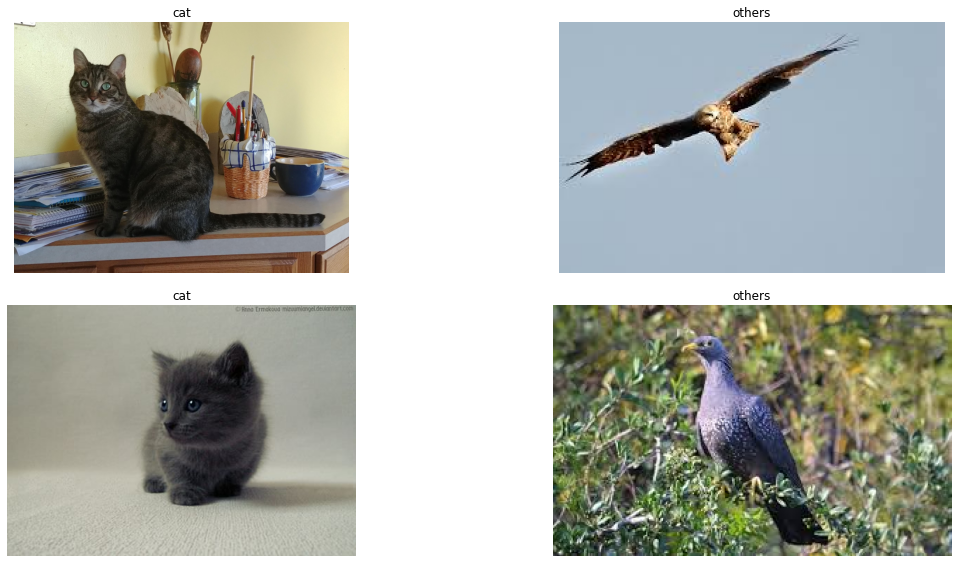

In [6]:
def show_n_images(dataset, n):
    # use np.unique to get all unique values in the list of labels
    labels = np.unique(dataset['label'])

    # set up the matplotlib figure and axes, based on the number of labels
    fig, axes = plt.subplots(n, len(labels))
    fig.set_size_inches(8 * len(labels), n*4)
    fig.tight_layout()

    # make a plot for every label (equipment) type. The index method returns the 
    # index of the first item corresponding to its search string, label in this case
    for i in range(len(labels)):
        label = labels[i]
        idx = 0
        for j in range(n):
            ax = axes[j][i]
            ax.axis('off')
            ax.set_title(label)
            for pos in range(idx, len(dataset['label'])):
                if dataset['label'][pos] == label:
                    ax.imshow(dataset['data'][pos])
                    idx = pos + 1
                    break
                    
show_n_images(dataset, 2)

We can see that our data is well sampled, with 100 cat images, and 100 other type of animals. We can also see that the images appear to be clear.

## Preprocessing

In the preprocessing stage, we will resize all the images to the same size

In [7]:
def resize_image(im, width, height):
    """
    Resize image into the specified height and width 
    using skimage.transform.resize.
     
    Parameter
    ---------
    im: 3d numpy array
        Image data
    width: int
        The expected output width
    height: int
        The expected output height
        
    Return
    ------
    3d numpy array
        The resized image data
    """
    return resize(im, (width, height))

def resize_images(images, width, height):
    """
    Resize all images into the specified width and height
    
    Parameter
    ---------
    images: dict
        Array with image data
    width: int
        The expected output width
    height: int
        The expected output height
        
    Return
    ------
    array
        The resized images data
    """
    resized_images = []
    for image in tqdm(images):
        resized_images.append(resize_image(image, width, height))
        
    return resized_images

We will now resize the images, and store the data in a pickle file.<br>
In later runs, we can directly load the data from the 

In [8]:
height = width = 64
#preprocessed_dataset = copy.deepcopy(dataset)
#preprocessed_dataset['data'] = resize_images(preprocessed_dataset['data'], width, height)

In [9]:
#joblib.dump(preprocessed_dataset , 'preprocessed_dataset.pkl')

In [10]:
preprocessed_dataset = joblib.load('preprocessed_dataset.pkl')

Next step is splitting the data into train and test datasets

In [11]:
X = np.array(preprocessed_dataset['data'])
y = np.array(preprocessed_dataset['label'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

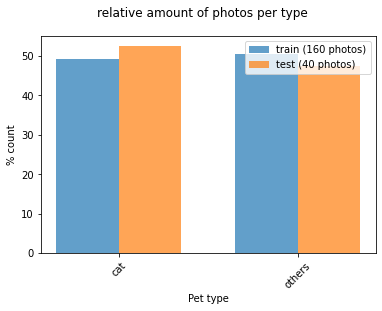

In [13]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('Pet type')
    plt.ylabel(ylabel_text)

plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

## Modelization & Performances evaluation

In this step, we will try to find the best model that is able to identify pictures of our favourite pet.<br>
We will try multiple approaches, and check which yields the best results.<br>

#### Baseline
To determine the baseline results, we will train SGD Classifier, on the raw data, without any transformations

In [14]:
def train_test_classifier(classifier, X_train, y_train, X_test, y_test):
    X_train_reshaped = X_train.reshape((X_train.shape[0],-1))
    X_test_reshaped = X_test.reshape((X_test.shape[0],-1))
    
    classifier.fit(X_train_reshaped, y_train)
    y_pred = classifier.predict(X_test_reshaped)
    accuracy = accuracy_score(y_test, y_pred) * 100
    return classifier, accuracy

baseline_sgd = SVC()
baseline_sgd, accuracy = train_test_classifier(baseline_sgd, 
                                               X_train,
                                               y_train,
                                               X_test,
                                               y_test)
print(f'Accuracy : {accuracy}')

Accuracy : 72.5


#### Improving the model

First approach we can try is transforming the image into grayscale, to reduce the dimension of the input

In [15]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([rgb2gray(img) for img in X])

In [16]:
# Create and fit instance of RGB2GrayTransformer
grayify = RGB2GrayTransformer()
grayify.fit(X_train)

#Transform Train and Test data
X_train_grayify = grayify.transform(X_train)
X_test_grayify = grayify.transform(X_test)

# Test model accuracy
sgd_1 = SVC()
sgd_1, accuracy = train_test_classifier(sgd_1,
                                        X_train_grayify,
                                        y_train,
                                        X_test_grayify,
                                        y_test)
print(f'Accuracy : {accuracy}')

Accuracy : 75.0


We can see a small improvement in the results, as the accuracy increases.<br>
The second approach we can implement is HOG feature extraction.<br>
In the next cell is an example usage of HOG to transform an image

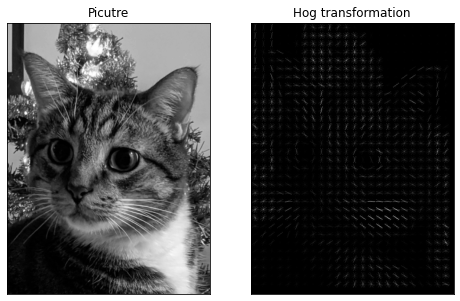

In [17]:
pic = imread('../datasets/dataset_cat/cat/cat_2.jpg', as_gray=True)
 
# scale down the image to one third
pic = rescale(pic, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
pic_hog, pic_hog_img = hog(
    pic, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(pic, cmap='gray')
ax[0].set_title('Picutre')
ax[1].imshow(pic_hog_img, cmap='gray')
ax[1].set_title('Hog transformation')
plt.show()

The picture is transformed, and the number of features is reduced.

In [18]:
print('number of pixels: ', pic.shape[0] * pic.shape[1])
print('number of hog features: ', pic_hog.shape[0])

number of pixels:  157094
number of hog features:  25668


In [19]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [20]:
# Create and fit instance of HogTransformer
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
hogify.fit(X_train)

#Transform Train and Test data
X_train_hog = hogify.transform(X_train_grayify)
X_test_hog = hogify.transform(X_test_grayify)

# Test model accuracy
sgd_1 = SVC()
sgd_1, accuracy = train_test_classifier(sgd_1,
                                        X_train_hog,
                                        y_train,
                                        X_test_hog,
                                        y_test)
print(f'Accuracy with hog: {accuracy}')

Accuracy with hog: 90.0


And if we try to combine HOG with Grayscaling the images

In [21]:
# Create and fit instance of HogTransformer
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
hogify.fit(X_train_grayify)

#Transform Train and Test data
X_train_hog = hogify.transform(X_train_grayify)
X_test_hog = hogify.transform(X_test_grayify)

# Test model accuracy
sgd_2 = SVC()
sgd_2, accuracy = train_test_classifier(sgd_2,
                                        X_train_hog,
                                        y_train,
                                        X_test_hog,
                                        y_test)
print(f'Accuracy with grayscaling and hog: {accuracy}')

Accuracy with grayscaling and hog: 90.0


The third change we can apply is scaling the images

In [22]:
# Create and fit instance of StandardScaler
scalify = StandardScaler()
scalify.fit(X_train.reshape(X_train.shape[0], -1))

#Transform Train and Test data
X_train_scaled = scalify.transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scalify.transform(X_test.reshape(X_test.shape[0], -1))

# Test model accuracy
sgd_3 = SVC()
sgd_3, accuracy = train_test_classifier(sgd_3,
                                        X_train_scaled,
                                        y_train,
                                        X_test_scaled,
                                        y_test)
print(f'Accuracy with scaling: {accuracy}')

Accuracy with scaling: 72.5


In [23]:
# Create and fit instance of StandardScaler
scalify = StandardScaler()
scalify.fit(X_train_hog)

#Transform Train and Test data
X_train_scaled = scalify.transform(X_train_hog)
X_test_scaled = scalify.transform(X_test_hog)

# Test model accuracy
sgd_4 = SVC()
sgd_4, accuracy = train_test_classifier(sgd_4,
                                        X_train_scaled,
                                        y_train,
                                        X_test_scaled,
                                        y_test)
print(f'Accuracy with grayscaling, HOG and scaling: {accuracy}')

Accuracy with grayscaling, HOG and scaling: 90.0


#### Hyper Parameter fine tuning

In [24]:
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC())
])

In [25]:
param_grid = [
    {
        'hogify__orientations': [7, 8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3), (4,4)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)],
        'classify': [
            SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
            SVC(gamma=1e-2),
            SVC(gamma=1e-3),
            SVC(gamma=1e-4),
            SVC()
        ]
    }
]

split_index = [0 if x in X_train else -1 for x in X]
pds = PredefinedSplit(test_fold = split_index)

grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid,
                           cv=pds,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X, y)

Fitting 1 folds for each of 135 candidates, totalling 135 fits


In [26]:
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer()), ('scalify', StandardScaler()),
                ('classify', SGDClassifier(random_state=42))])

Let's plot the confusion matrix of the best classifier using Grid Search

C:\Users\elies\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


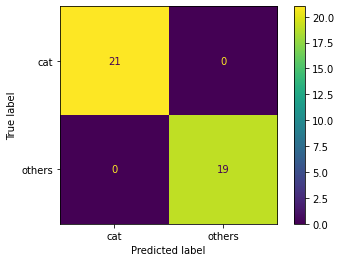

In [27]:
plot_confusion_matrix(grid_res.best_estimator_, X_test, y_test)

C:\Users\elies\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


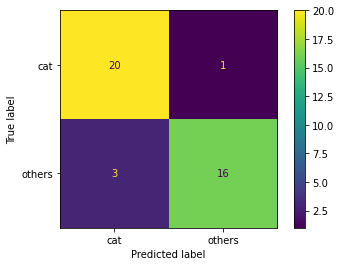

In [28]:
plot_confusion_matrix(sgd_4, X_test_scaled, y_test)

We can observe that using Grid Search we were able to come up with a perfect clssifier, where accuracy is up to 100%<br>
Next step, is using a pre-trained model from Tensorflow hub, where we will fine tune the last layer on our classes, and check the results

## Transfer Learning with Tensorflow Hub
Inspired from https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

In [29]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.data import AUTOTUNE
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_hub as hub
import datetime
%load_ext tensorboard

In [30]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = image_dataset_from_directory(
  '../datasets/dataset_cat',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = image_dataset_from_directory(
  '../datasets/dataset_cat',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


In [31]:
class_names = np.array(train_ds.class_names)
class_names

array(['cat', 'others'], dtype='<U6')

The dataset is loaded correctly, and the classes properly identified

In order to adhere to tensorflow convention, we will rescale the data into range of [0,1] 

In [32]:
normalization_layer = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

And according to the given advice, we will finetune tensoflow to avoid IO issues

In [33]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Building the model

In [34]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [35]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_height, img_width, 3),
    trainable=False)

In [36]:
num_classes = len(class_names)

model = Sequential([
  feature_extractor_layer,
  Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


#### Fine tuning the model

In [37]:
model.compile(
  optimizer=Adam(),
  loss=SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [38]:
NUM_EPOCHS = 20

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/20
5/5 [==============================] - 12s 1s/step - loss: 0.5454 - acc: 0.6687 - val_loss: 0.4709 - val_acc: 0.7250
Epoch 2/20
5/5 [==============================] - 5s 1s/step - loss: 0.3101 - acc: 0.9187 - val_loss: 0.2933 - val_acc: 0.9250
Epoch 3/20
5/5 [==============================] - 5s 1s/step - loss: 0.1873 - acc: 0.9625 - val_loss: 0.1994 - val_acc: 0.9750
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 0.1240 - acc: 0.9875 - val_loss: 0.1428 - val_acc: 0.9750
Epoch 5/20
5/5 [==============================] - 6s 1s/step - loss: 0.0943 - acc: 0.9937 - val_loss: 0.1113 - val_acc: 0.9750
Epoch 6/20
5/5 [==============================] - 5s 1s/step - loss: 0.0745 - acc: 0.9937 - val_loss: 0.0920 - val_acc: 1.0000
Epoch 7/20
5/5 [==============================] - 5s 1s/step - loss: 0.0599 - acc: 0.9937 - val_loss: 0.0798 - val_acc: 1.0000
Epoch 8/20
5/5 [==============================] - 6s 1s/step - loss: 0.0495 - acc: 0.9937 - val_loss: 0.0710 -

To visualize the training metrics, we will use tensorboard.

In [39]:
%tensorboard --logdir logs/fit

## Conclusion

In this conclusion, i'll list all the new techniques I learned in order to complete the required tasks, and the challenges I faced, as well as any future improvements we can implement to get better results. 

#### What I learned

* skimage:<br>
    This is a new library, that is useful for processing images, it offers functionalities such as:<br>
        * hog algorithm for feature extraction<br>
        * reading images from disk<br>
        * resizing, rescaling and transforming colored images into grayscale<br>
* RGB to Gray Transformation:<br>
    This transformation allows us to reduce the sinze of the images, and can be useful in the cases the colors are not an important feature in the image.
* HOG feature extraction:<br>
    This is useful for reducing the number of the features in an image as well, by detecting features in the image.
* Using and fine-tuning tensoflow hub models

#### Challenges faced

The most interesting challenge was where to start from, how to build a dataset, and how to do feature engineering. There were a lot of resources online, with different approaches, from the very simple, to teh most complex neural networks. Following this tutorial, I was able to complete the task at hand, and get very good results.

#### Future Improvements

There are a lot of extra steps we can apply to get better performances, including:
* Gamma Correction
* Histogram equalization
* Image Segmentation